<a href="https://colab.research.google.com/github/Galahexolion/Giliojo-mokymo-sistem-taikymai/blob/main/Lab5_parameters/Lab5_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 30 Complete [00h 01m 19s]
val_accuracy: 0.8352500200271606

Best val_accuracy So Far: 0.8889999985694885
Total elapsed time: 00h 22m 07s

Paieška baigta. 
Optimalus neuronų skaičius: 448
Optimalus Dropout: 0.30000000000000004
Optimalus Learning Rate: 0.001

Mokome geriausią modelį...
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7717 - loss: 0.6562 - val_accuracy: 0.8510 - val_loss: 0.4089
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8470 - loss: 0.4153 - val_accuracy: 0.8649 - val_loss: 0.3761
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8597 - loss: 0.3810 - val_accuracy: 0.8710 - val_loss: 0.3592
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8691 - loss: 0.3512 - val_accuracy: 0.8776 - val_loss: 0.3350
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8729 - loss: 0.3399 - val_accuracy: 0.8741 - val_loss: 0.3415
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step

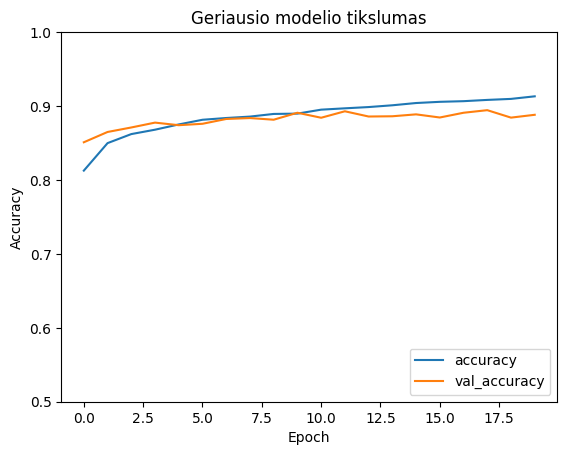

In [7]:
# --- 1. DUOMENŲ PARUOŠIMAS (Fashion MNIST) ---

# 1. Įdiegiame keras-tuner (būtina Colab aplinkoje)
!pip install keras-tuner -q

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt

# Tai panašus į MNIST, bet su drabužiais (sunkesnis uždavinys)
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalizuojame į [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"Mokymo duomenys: {x_train.shape}")
print(f"Testavimo duomenys: {x_test.shape}")

# --- 2. MODELIO KŪRIMO FUNKCIJA (su kintamais parametrais) ---

def build_model(hp):
    model = keras.Sequential()

    # Ištiesiname 28x28 paveiksliuką į vektorių
    model.add(layers.Flatten(input_shape=(28, 28)))

    # --- PARAMETRŲ PAIEŠKA ---

    # 1. Ieškome optimalaus neuronų skaičiaus pirmame sluoksnyje (tarp 32 ir 512)
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(layers.Dense(units=hp_units, activation='relu'))

    # 2. Ieškome optimalaus Dropout (nuo 0.0 iki 0.5)
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout))

    # Išėjimo sluoksnis (10 klasių)
    model.add(layers.Dense(10, activation='softmax'))

    # 3. Ieškome optimalaus mokymosi greičio (learning rate)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# --- 3. TUNER INICIALIZAVIMAS ---
# Naudojame Hyperband algoritmą (greitas ir efektyvus)
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Sustabdome paiešką, jei modelis nebesimoko (EarlyStopping)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("\n--- Pradedama hiperparametrų paieška ---")
tuner.search(x_train, y_train,
             epochs=10,
             validation_split=0.2,
             callbacks=[stop_early])

# --- 4. GERIAUSIŲ PARAMETRŲ REZULTATAI ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Paieška baigta.
Optimalus neuronų skaičius: {best_hps.get('units')}
Optimalus Dropout: {best_hps.get('dropout')}
Optimalus Learning Rate: {best_hps.get('learning_rate')}
""")

# --- 5. GERIAUSIO MODELIO MOKYMAS ---
print("Mokome geriausią modelį...")
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train,
                    epochs=20,
                    validation_split=0.2,
                    verbose=1)

# Įvertinimas
eval_result = model.evaluate(x_test, y_test)
print(f"\nTestavimo tikslumas: {eval_result[1]:.4f}")

# --- 6. VIZUALIZACIJA ---
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Geriausio modelio tikslumas")
plt.show()